# DistilBert

## Imports

In [ ]:
!pip install datasets requests==2.31.0 pyarrow==14.0.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 52.8 MB/s eta 0:00:00


In [ ]:
import transformers
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

## Parameters

In [ ]:
class CFG:
    MODEL = "distilbert-base-uncased"
    NUM_LABELS = 5
    EPOCHS = 10
    LR = 2e-5
    BATCH_SIZE = 16
    OUTPUT_DIR = "./results"
    WEIGHT_DECAY = 0.01

In [ ]:
dataset = load_dataset("SetFit/sst5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [ ]:
def plot_confusion_matrix(y_true, y_pred,
                          class_dict=
                           {0: 'Very Negative', 1: 'Negative', 2: 'Neutral', 3: 'Positive', 4: 'Very Positive'}):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_dict.values()), yticklabels=list(class_dict.values()))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        labels = self.dataset[idx]['label']

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True, # Add [CLS] at the start
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(labels, dtype=torch.long)
        }

tokenizer = transformers.DistilBertTokenizer.from_pretrained(CFG.MODEL)
training_set = SentimentDataset(dataset['train'], tokenizer, 512)
val_set = SentimentDataset(dataset['validation'], tokenizer, 512)
test_set = SentimentDataset(dataset['test'], tokenizer, 512)

train_loader = DataLoader(training_set, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=CFG.BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=CFG.BATCH_SIZE)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Loading Dataset

In [ ]:
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

In [ ]:
train_df.head()

,text,label,label_text
0,"a stirring , funny and finally transporting re...",4,very positive
1,apparently reassembled from the cutting-room f...,1,negative
2,they presume their audience wo n't sit still f...,1,negative
3,the entire movie is filled with deja vu moments .,2,neutral
4,this is a visually stunning rumination on love...,3,positive


In [ ]:
print(f"Number of training samples: {train_df.shape}")
print(f"Number of validation samples: {validation_df.shape}")
print(f"Number of testing samples: {test_df.shape}")

Number of training samples: (8544, 3)
Number of validation samples: (1101, 3)
Number of testing samples: (2210, 3)


<Axes: title={'center': 'Testing Set Score Count'}, xlabel='label', ylabel='count'>

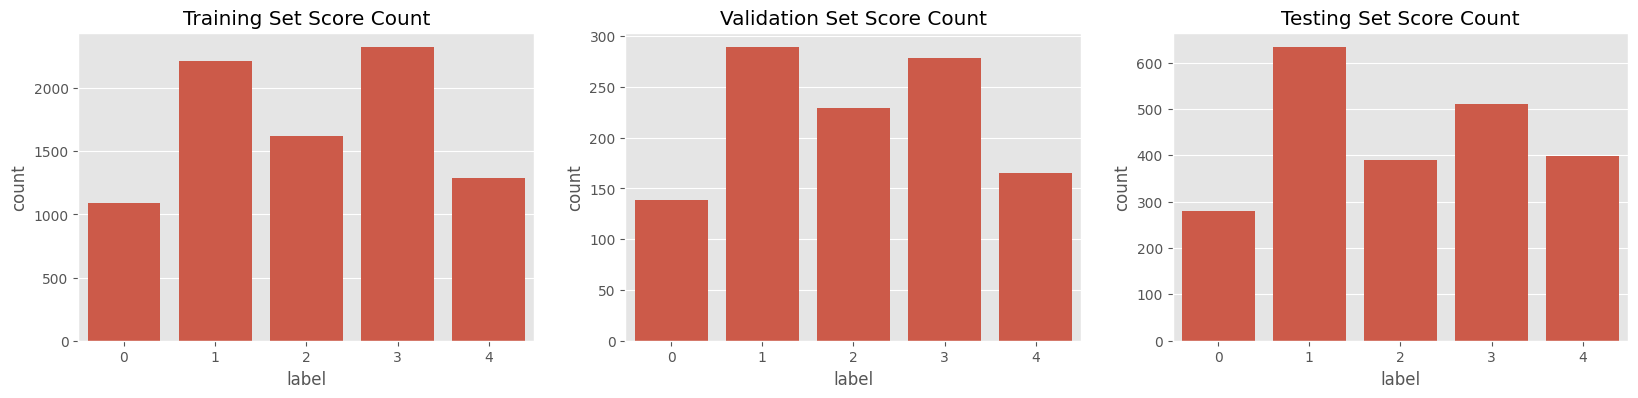

In [ ]:
plt.figure(figsize=(20, 4))
plt.style.use('ggplot')
plt.subplot(1, 3, 1)
plt.title("Training Set Score Count")
sns.countplot(train_df, x="label")

plt.subplot(1, 3, 2)
plt.title("Validation Set Score Count")
sns.countplot(validation_df, x="label")

plt.subplot(1, 3, 3)
plt.title("Testing Set Score Count")
sns.countplot(test_df, x="label")

## Preparing Model Methods

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_prob=0.7):
        super(SentimentClassifier, self).__init__()
        self.config = transformers.DistilBertConfig.from_pretrained(model_name, num_labels=num_labels)
        self.distilbert = transformers.DistilBertModel.from_pretrained(model_name, config=self.config)
        self.pre_classifier = nn.Linear(self.config.hidden_size, self.config.hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

model = SentimentClassifier(CFG.MODEL, CFG.NUM_LABELS).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (logits.argmax(1) == labels).type(torch.float).sum().item()

        if batch_idx % 100 == 0:
            current = batch_idx * CFG.BATCH_SIZE + len(input_ids)
            print(f"Batch {batch_idx + 1}, loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    print(f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {average_train_loss:>8f} \n")
    return average_train_loss, train_accuracy

In [ ]:
def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            val_loss += loss_fn(logits, labels).item()
            correct += (logits.argmax(1) == labels).type(torch.float).sum().item()

    average_val_loss = val_loss / num_batches
    val_accuracy = correct / size
    print(f"Validation Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Validation loss: {average_val_loss:>8f} \n")
    return average_val_loss, val_accuracy

In [ ]:
def evaluate_model(loader, model, loss_fn):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    correct_examples = []
    incorrect_examples = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            predictions = logits.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

            matches = predictions == labels
            for i in range(len(matches)):
                example = (input_ids[i].cpu(), labels[i].item(), predictions[i].item())
                if matches[i]:
                    correct_examples.append(example)
                else:
                    incorrect_examples.append(example)

    average_loss = total_loss / len(loader)
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    return y_true, y_pred, average_loss, accuracy, correct_examples, incorrect_examples

## Training

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
val_losses = []
train_accs = []
test_accs = []
val_accs = []
max_acc = 0
for t in range(CFG.EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if max_acc < val_acc:
        print(
            f"[SAVING] Validation Accuracy Increased({(100*max_acc):>0.1f}% ---> {(100*val_acc):>0.1f}%)"
        )
        max_acc = val_acc
        torch.save(model.state_dict(), "save_model.pth")

Epoch 1
-------------------------------
Batch 1, loss: 1.091939  [   16/ 8544]
Batch 101, loss: 1.217620  [ 1616/ 8544]
Batch 201, loss: 1.621434  [ 3216/ 8544]
Batch 301, loss: 1.386250  [ 4816/ 8544]
Batch 401, loss: 0.938800  [ 6416/ 8544]
Batch 501, loss: 1.044312  [ 8016/ 8544]
Training Error: 
 Accuracy: 48.3%, Avg loss: 1.179218 

Validation Error: 
 Accuracy: 46.8%, Validation loss: 1.205127 

[SAVING] Validation Accuracy Increased(0.0% ---> 46.8%)
Epoch 2
-------------------------------
Batch 1, loss: 1.025957  [   16/ 8544]
Batch 101, loss: 1.028594  [ 1616/ 8544]
Batch 201, loss: 0.761328  [ 3216/ 8544]
Batch 301, loss: 1.195823  [ 4816/ 8544]
Batch 401, loss: 0.967262  [ 6416/ 8544]
Batch 501, loss: 0.871793  [ 8016/ 8544]
Training Error: 
 Accuracy: 57.5%, Avg loss: 0.971757 

Validation Error: 
 Accuracy: 50.8%, Validation loss: 1.186468 

[SAVING] Validation Accuracy Increased(46.8% ---> 50.8%)
Epoch 3
-------------------------------
Batch 1, loss: 0.583592  [   16/ 8544

## Results

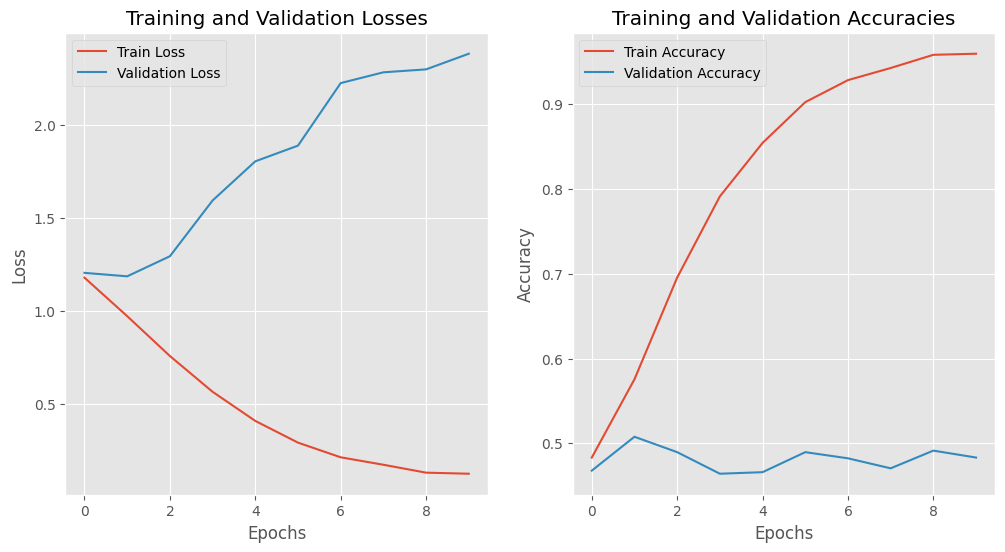

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
model.load_state_dict(torch.load("save_model.pth"))
model.to(device)

SentimentClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

y_true, y_pred, test_loss, test_accuracy, correct_examples, incorrect_examples = evaluate_model(test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.1260
Test Accuracy: 0.5127


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.58      0.50       279
           1       0.51      0.63      0.56       633
           2       0.46      0.21      0.29       389
           3       0.49      0.65      0.56       510
           4       0.72      0.41      0.52       399

    accuracy                           0.51      2210
   macro avg       0.53      0.49      0.49      2210
weighted avg       0.53      0.51      0.50      2210



## Confusion Matrix

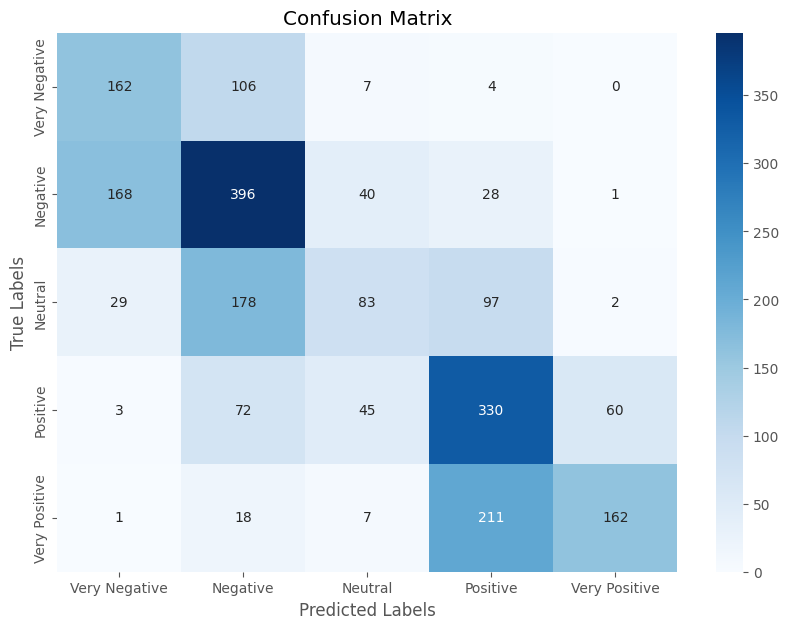

In [ ]:
plot_confusion_matrix(y_true, y_pred)